In [5]:
# data preprocessing
import rasterio
from rasterio.mask import mask
from shapely.geometry import Polygon
from rasterio.plot import show
import matplotlib.pyplot as plt
from rasterio.enums import Resampling
import numpy as np

#viewshed
from uuid import uuid1
from os import makedirs
from affine import Affine
from os.path import exists
from math import exp, hypot
# from time import perf_counter
from rasterio import open as rio_open
from rasterio.transform import rowcol, xy
from skimage.draw import line, disk, circle_perimeter
from numpy import zeros, unique, multiply, array, column_stack
from tqdm import tqdm

C:\Users\Ondrej\miniconda3\lib\site-packages\skimage\util\dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


# Initial file inspection

In [2]:
# check the metadata, coordinate system and elavation on files
with rasterio.open('DSM_merged.tif') as src:
    print(src.profile)
    print("DSM CRS:", src.crs)
    
    elevation = src.read(1)
    print("Minimum elevation:", elevation.min())
    print("Maximum elevation:", elevation.max())
    print("Mean elevation:", elevation.mean())
    resolution = src.res # resolution
    print("Resolution: {}".format(resolution))
    
    
with rasterio.open('DTM.tif') as src:
    print(src.profile)
    print("DTM CRS:", src.crs)
    
    elevation = src.read(1)
    print("Minimum elevation:", elevation.min())
    print("Maximum elevation:", elevation.max())
    print("Mean elevation:", elevation.mean())
    resolution = src.res # resolution
    print("Resolution: {}".format(resolution))
    
with rasterio.open('20200629_gm_Bomenkaart_v2.tif') as src:
    print(src.profile)
    print("Greeness CRS:", src.crs)
    resolution = src.res # resolution
    print("Resolution: {}".format(resolution))

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 43000, 'height': 62500, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["Amersfoort / RD New",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(5.0, 0.0, 10000.0,
       0.0, -5.0, 618750.0), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
DSM CRS: LOCAL_CS["Amersfoort / RD New",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Minimum elevation: -12.249995
Maximum elevation: 341.1837
Mean elevation: 3.1893654
Resolution: (5.0, 5.0)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 43000, 'height': 62500, 'count': 1, 'crs': CRS.from_wkt('LOCAL_CS["Amersfoort / RD New",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(5.0, 0.0, 10000.0,
       0.0, -5.0, 618750.0), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
DTM CRS: LOCAL_CS["Amersfoort / RD Ne

# Date preprocessing 

### Resample Bomenkaart

In [2]:
# resample bomenkaart to 5x5 to match the DSM and DTM
with rasterio.open("20200629_gm_Bomenkaart_v2.tif") as src:
    # Resample to 5x5
    data = src.read(
        out_shape=(
            src.count,
            int(src.height * src.res[0] / 5),
            int(src.width * src.res[1] / 5)
        ),
        resampling=Resampling.bilinear
    )
    # Update the metadata
    transform = src.transform * src.transform.scale(
        (src.width / data.shape[-1]),
        (src.height / data.shape[-2])
    )
    profile = src.profile
    profile.update(transform=transform, width=data.shape[-1], height=data.shape[-2])

    # Save it as a new file
    with rasterio.open("20200629_gm_Bomenkaart_v2_resampled.tif", "w", **profile) as dst:
        dst.write(data)

In [5]:
# check new resolution
with rasterio.open('20200629_gm_Bomenkaart_v2_resampled.tif') as src:
    resolution = src.res # resolution
    print("Resolution: {}".format(resolution))

Resolution: (5.0, 5.0)


### Sample area to Amsterdam

In [74]:
def sample_raster(input_file, output_file, extent):
    """the function samples a large raster file based on a defined
    extent"""
    # Define the polygon based on the given extent
    polygon = Polygon(extent)
    
    with rasterio.open(input_file) as src:
        out_image, out_transform = mask(src, [polygon], crop=True)
        out_meta = src.meta.copy()

    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    with rasterio.open(output_file, "w", **out_meta) as dest:
        dest.write(out_image)

# Amsterdam extent as defined by osm
amsterdam_extent = ([
    (110197.58886262693, 481267.75186291605),
    (110197.58886262693, 493760.8223725179),
    (133222.64516566016, 493760.8223725179),
    (133222.64516566016, 481267.75186291605),
    (110197.58886262693, 481267.75186291605) 
])

sample_raster("DSM_merged.tif", "DSM_merged_ams.tif", amsterdam_extent)
sample_raster("DTM.tif", "DTM_ams.tif", amsterdam_extent)
sample_raster("20200629_gm_Bomenkaart_v2_resampled.tif", "20200629_gm_Bomenkaart_v2_resampled_ams.tif", amsterdam_extent)

### Set a threshold for tree probability

In [86]:
with rasterio.open('20200629_gm_Bomenkaart_v2_resampled_ams.tif') as src:
    data = src.read(1)

    # new array with values above +10
    new_data = data.copy()
    new_data[new_data <= 10] = 0
    new_data[new_data > 10] = 1

    # use metadata from the input
    meta = src.meta

with rasterio.open('20200629_gm_Bomenkaart_v2_resampled_ams_trees.tif', 'w', **meta) as dst: # store into a new file 
    dst.write(new_data, 1)

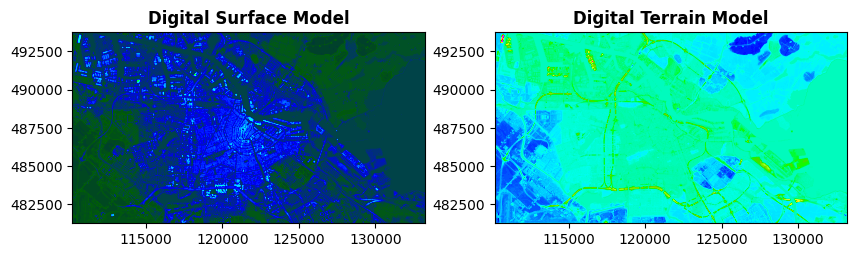

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5), dpi=100)

# visualise the sampled DSM file
dsm = rasterio.open("DSM_merged_ams.tif", driver="GTiff")
show(dsm, title='Digital Surface Model', cmap='gist_ncar', ax=ax[0])
dsm.close()

# visualise the sampled DTM file
dtm = rasterio.open("DTM_ams.tif", driver="GTiff")
show(dtm, title='Digital Terrain Model', cmap='gist_ncar', ax=ax[1])
dtm.close()

plt.show()

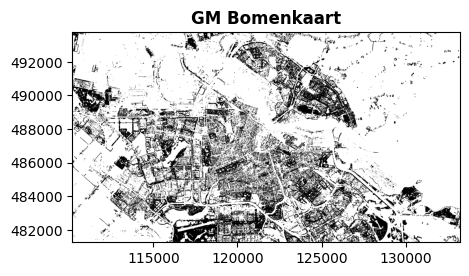

In [8]:
# visualise the sampled tree file
trees = rasterio.open("20200629_gm_Bomenkaart_v2_resampled_ams_trees.tif", driver="GTiff")

plt.figure(figsize=(5, 5), dpi=100)  # adjust size and resolution
show(trees, title='GM Bomenkaart', cmap = 'binary')

trees.close()

# Viewshed analysis

In [9]:
def coords2Array(a, x, y):
    """
    * convert between coords and array position
    *  returns row,col (y,x) as expected by rasterio
    """
    r, c = rowcol(a, x, y)
    return int(r), int(c)


def array2Coords(a, row, col):
    """
    * convert between array position and coords
    *  params are row,col (y,x) as expected by rasterio
    *  returns coords at the CENTRE of the cell
    """
    x, y = xy(a, row, col)
    return int(x), int(y)


def viewshed(r0, c0, radius_px, resolution, observerHeight, targetHeight, dsm_data, dtm_data, a):
    """
    * Use Bresenham's Circle / Midpoint algorithm to determine endpoints for viewshed
    """

    # create output array at the same dimensions as data for viewshed
    output = zeros(dtm_data.shape)

    # set the start location as visible automatically
    output[(r0, c0)] = 1

    # get pixels in the circle
    for r, c in column_stack(circle_perimeter(r0, c0, radius_px)):

        # calculate line of sight to each pixel
        output = lineOfSight(r0, c0, r, c, resolution, observerHeight, targetHeight, dsm_data, dtm_data, output)

    # return the resulting viewshed
    return output

def lineOfSight(r0, c0, r1, c1, observer_height, resolution, target_height, dsm_data, dtm_data, output):
    """
     * Runs a single ray-trace from one point to another point, returning a list of visible cells
    """

    # init variables for loop
    cur_dydx = 0 		  	# current dydx (base of object)
    max_dydx = 0 	  		# biggest dydx so far
    # top_dydx = 0 		    # current dydx (top of object)
    distance_travelled = 0  # how far we have travelled along the ray

    # get the viewer height
    height0 = dtm_data[(r0, c0)] + observer_height

    # get the pixels in the line (excluding the first one	)
    pixels = column_stack(line(r0, c0, r1, c1))[1:]

    # loop along the pixels in the line
    for r, c in pixels:

        # distance travelled so far
        distance_travelled = hypot(c0 - c, r0 - r)

        ''' comment this out as long as we use 0 as target offset '''
        ## set cell as visible if the height of the top of the object from the DTM > previous max
        # top_dydx = (dsm_data[(r, c)] - height0 + target_height) / distance_travelled
        # if (top_dydx >= max_dydx):
        # 	output[(r, c)] = 1
        #
        ## update max dydx the height of the base of the object on the DSM > previous max
        # cur_dydx = (dsm_data[(r, c)] - height0) / distance_travelled
        # if (cur_dydx > max_dydx):
        # 	max_dydx = cur_dydx

        # update max dydx the height of the base of the object on the DSM > previous max
        cur_dydx = (dsm_data[(r, c)] - height0) / (distance_travelled * resolution)
        if (cur_dydx > max_dydx):
            max_dydx = cur_dydx
            output[(r, c)] = 1

    # return updated output surface
    return output


def f2(mask):
    """
    * main function for running with parallel.py
    """

    # create an output array at the same dimensions as data for output
    gvi = zeros((mask["meta"]["height"], mask["meta"]["width"]))

    # radius in pixels
    radius_px = int(mask["options"]["radius"] // mask['meta']['transform'][0])

    # build weighting mask
    weighting_mask = zeros((radius_px*2, radius_px*2))
    for r, c in column_stack(disk((radius_px, radius_px), radius_px, shape=weighting_mask.shape)):
        weighting_mask[(r, c)] = exp(-0.0003 * (hypot(radius_px - c, radius_px - r) * mask['meta']['transform'][0]))

    # get pixel references for aoi extents
    min_r, min_c  = coords2Array(mask["meta"]["transform"], mask["aoi"].bounds[0], mask["aoi"].bounds[3])
    max_r, max_c  = coords2Array(mask["meta"]["transform"], mask["aoi"].bounds[2], mask["aoi"].bounds[1])

    total_points = (max_r - min_r + 1) * (max_c - min_c + 1)
    points_processed = 0

    # loop through dataset rows and columns
    for r in range(min_r, max_r+1):
        for c in range(min_c, max_c+1):

            # call (weighted) viewshed
            output = viewshed(r, c, radius_px, 		# coords and radius in pixels
                mask['meta']['transform'][0],		# resolution of datasets
                mask["options"]["o_height"], 		# observer height
                mask["options"]["t_height"],		# target height
                mask["dsm"], 						# dsm dataset
                mask["dtm"],						# dtm dataset
                mask["meta"]["transform"])			# affine transform

            # extract the viewshed data from the output surface and apply weighting mask
            visible = output[r-radius_px:r+radius_px, c-radius_px:c+radius_px] * weighting_mask

            # multiply extract of (weighted) viewshed with extract of (weighted) green dataset
            visible_green = visible * (mask["green"][r-radius_px:r+radius_px, c-radius_px:c+radius_px] * weighting_mask)

            # get the ratio for greenness in the view
            gvi[(r,c)] = visible_green.sum() / visible.sum()

            points_processed += 1
            progress = points_processed / total_points
            tqdm.write(f"Progress: {progress:.2%}", end='\r')
            

    # clip gvi to aoi bounds
    gvi = gvi[min_r:max_r+1, min_c:max_c+1]

    # check that tmp folder exists
    if not exists('./tmp/'):
        makedirs('tmp')

    # make unique filename
    filepath = f'./tmp/{str(uuid1())[:8]}.tif'
    
    # output file with updated dimensions and transform
    with rio_open(filepath, 'w',
        driver =	mask["meta"]["driver"],
        height = 	gvi.shape[0],
        width =		gvi.shape[1],
        count =		mask["meta"]["count"],
        dtype =		'float64',
        crs =		mask["meta"]["crs"],
        transform =	Affine(
            mask['meta']['transform'][0],
            mask['meta']['transform'][1],
            mask["aoi"].bounds[0],
            mask['meta']['transform'][3],
            mask['meta']['transform'][4],
            mask["aoi"].bounds[3]),
        ) as dst:
        dst.write(gvi, 1)

    # return the filepath to the result
    return filepath


"""
* Do not call this script directly
"""
if __name__ == '__main__':
	print("please call this script using parallel.py")

please call this script using parallel.py


### Viewshed test

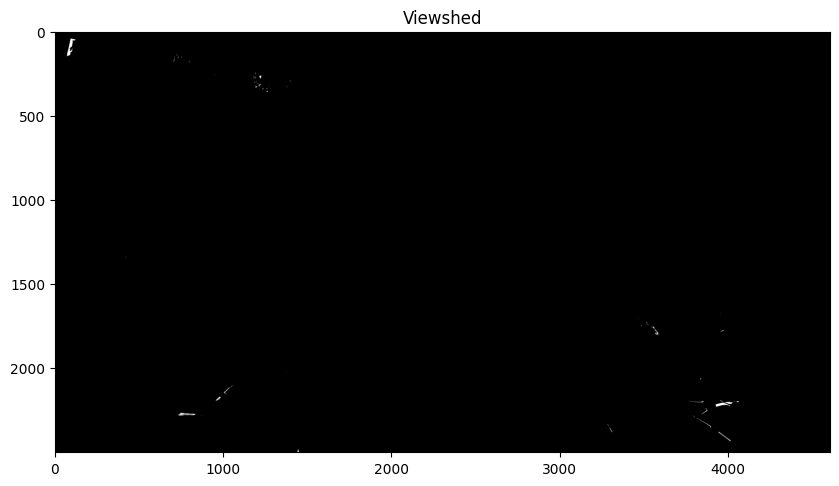

In [17]:
with rasterio.open('DTM_ams.tif') as dsm:
    dsm_data = dsm.read(1)

with rasterio.open('DSM_merged_ams.tif') as dtm:
    dtm_data = dtm.read(1)

r0 = 20
c0 = 10 
radius_px = 1500 
resolution = 5.0 
observerHeight = 2.0 
targetHeight = 0.0 # height of target above the ground in meters
a = 0.13 # coefficient used for adjusting visibility of each cell

output = viewshed(r0, c0, radius_px, resolution, observerHeight, targetHeight, dsm_data, dtm_data, a)

# convert boolean
output = output.astype(np.uint8)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(output, cmap='gray')
ax.set_title('Viewshed')
plt.show()

### OSM street network data

In [31]:
import osmnx as ox
import geopandas as gpd

# region specificaiton
region = "Amsterdam"
G = ox.graph_from_place(region, network_type="all") # get all networks for the given region
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G) # convert the graph to a GeoDataFrame

# reproject to the matching projection with dtm and dsm
gdf_nodes = gdf_nodes.to_crs('EPSG:28992')
gdf_edges = gdf_edges.to_crs('EPSG:28992')

In [30]:
# save edges as shp file
gdf_edges['name'] = gdf_edges['name'].astype(str)
gdf_edges[['name', 'geometry']].to_file("street_osm/streets_ams.shp")

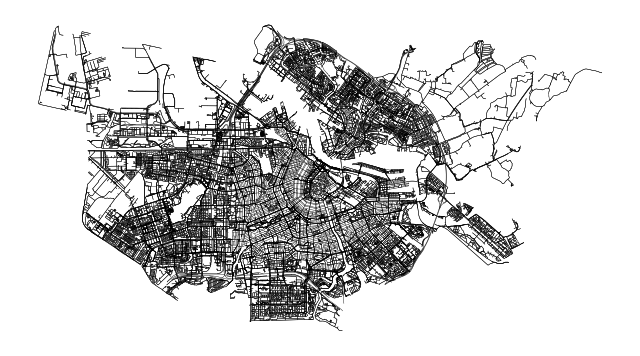

In [34]:
# visualise the street network
ax = gdf_edges.plot(color='black', linewidth=0.3, figsize=(8, 8))
ax.set_axis_off()

###  GVI calculation - streets

In [72]:
dsm_path = 'DSM_merged_ams.tif'
dtm_path = 'DTM_ams.tif'
green_path = '20200629_gm_Bomenkaart_v2_resampled_ams_trees.tif'

with rasterio.open(dsm_path) as src:
    dsm = src.read(1)

with rasterio.open(dtm_path) as src:
    dtm = src.read(1)

with rasterio.open(green_path) as src:
    green = src.read(1)

# create a list of all the geometries in the gdf edges
geoms = list(gdf_edges.geometry.values)

# mask for all geometries
mask_streets = rasterio.features.geometry_mask(geoms, out_shape=dsm.shape, transform=meta['transform'], invert=False)
mask_streets = mask_streets.astype(int) # convert to boolean

# use the mask on the DSM, DTM, and tree data
dsm_streets = np.ma.array(dsm, mask=(mask_streets == 0))
dtm_streets = np.ma.array(dtm, mask=(mask_streets == 0))
masked_green_streets = np.ma.array(green, mask=((mask_streets == 0) | (mask == 0)))

In [60]:
# check the counts of 1s and 0s
counts = np.bincount(masked_green_streets.flatten())

# Print the counts
print(f"Number of non-street pixels (0) {counts[0]}")
print(f"Number of street pixels (1): {counts[1]}")
print(f"Tota: {counts[0] + counts[1]}")

Number of non-street pixels (0) 9074939
Number of street pixels (1): 2440061
Tota: 11515000


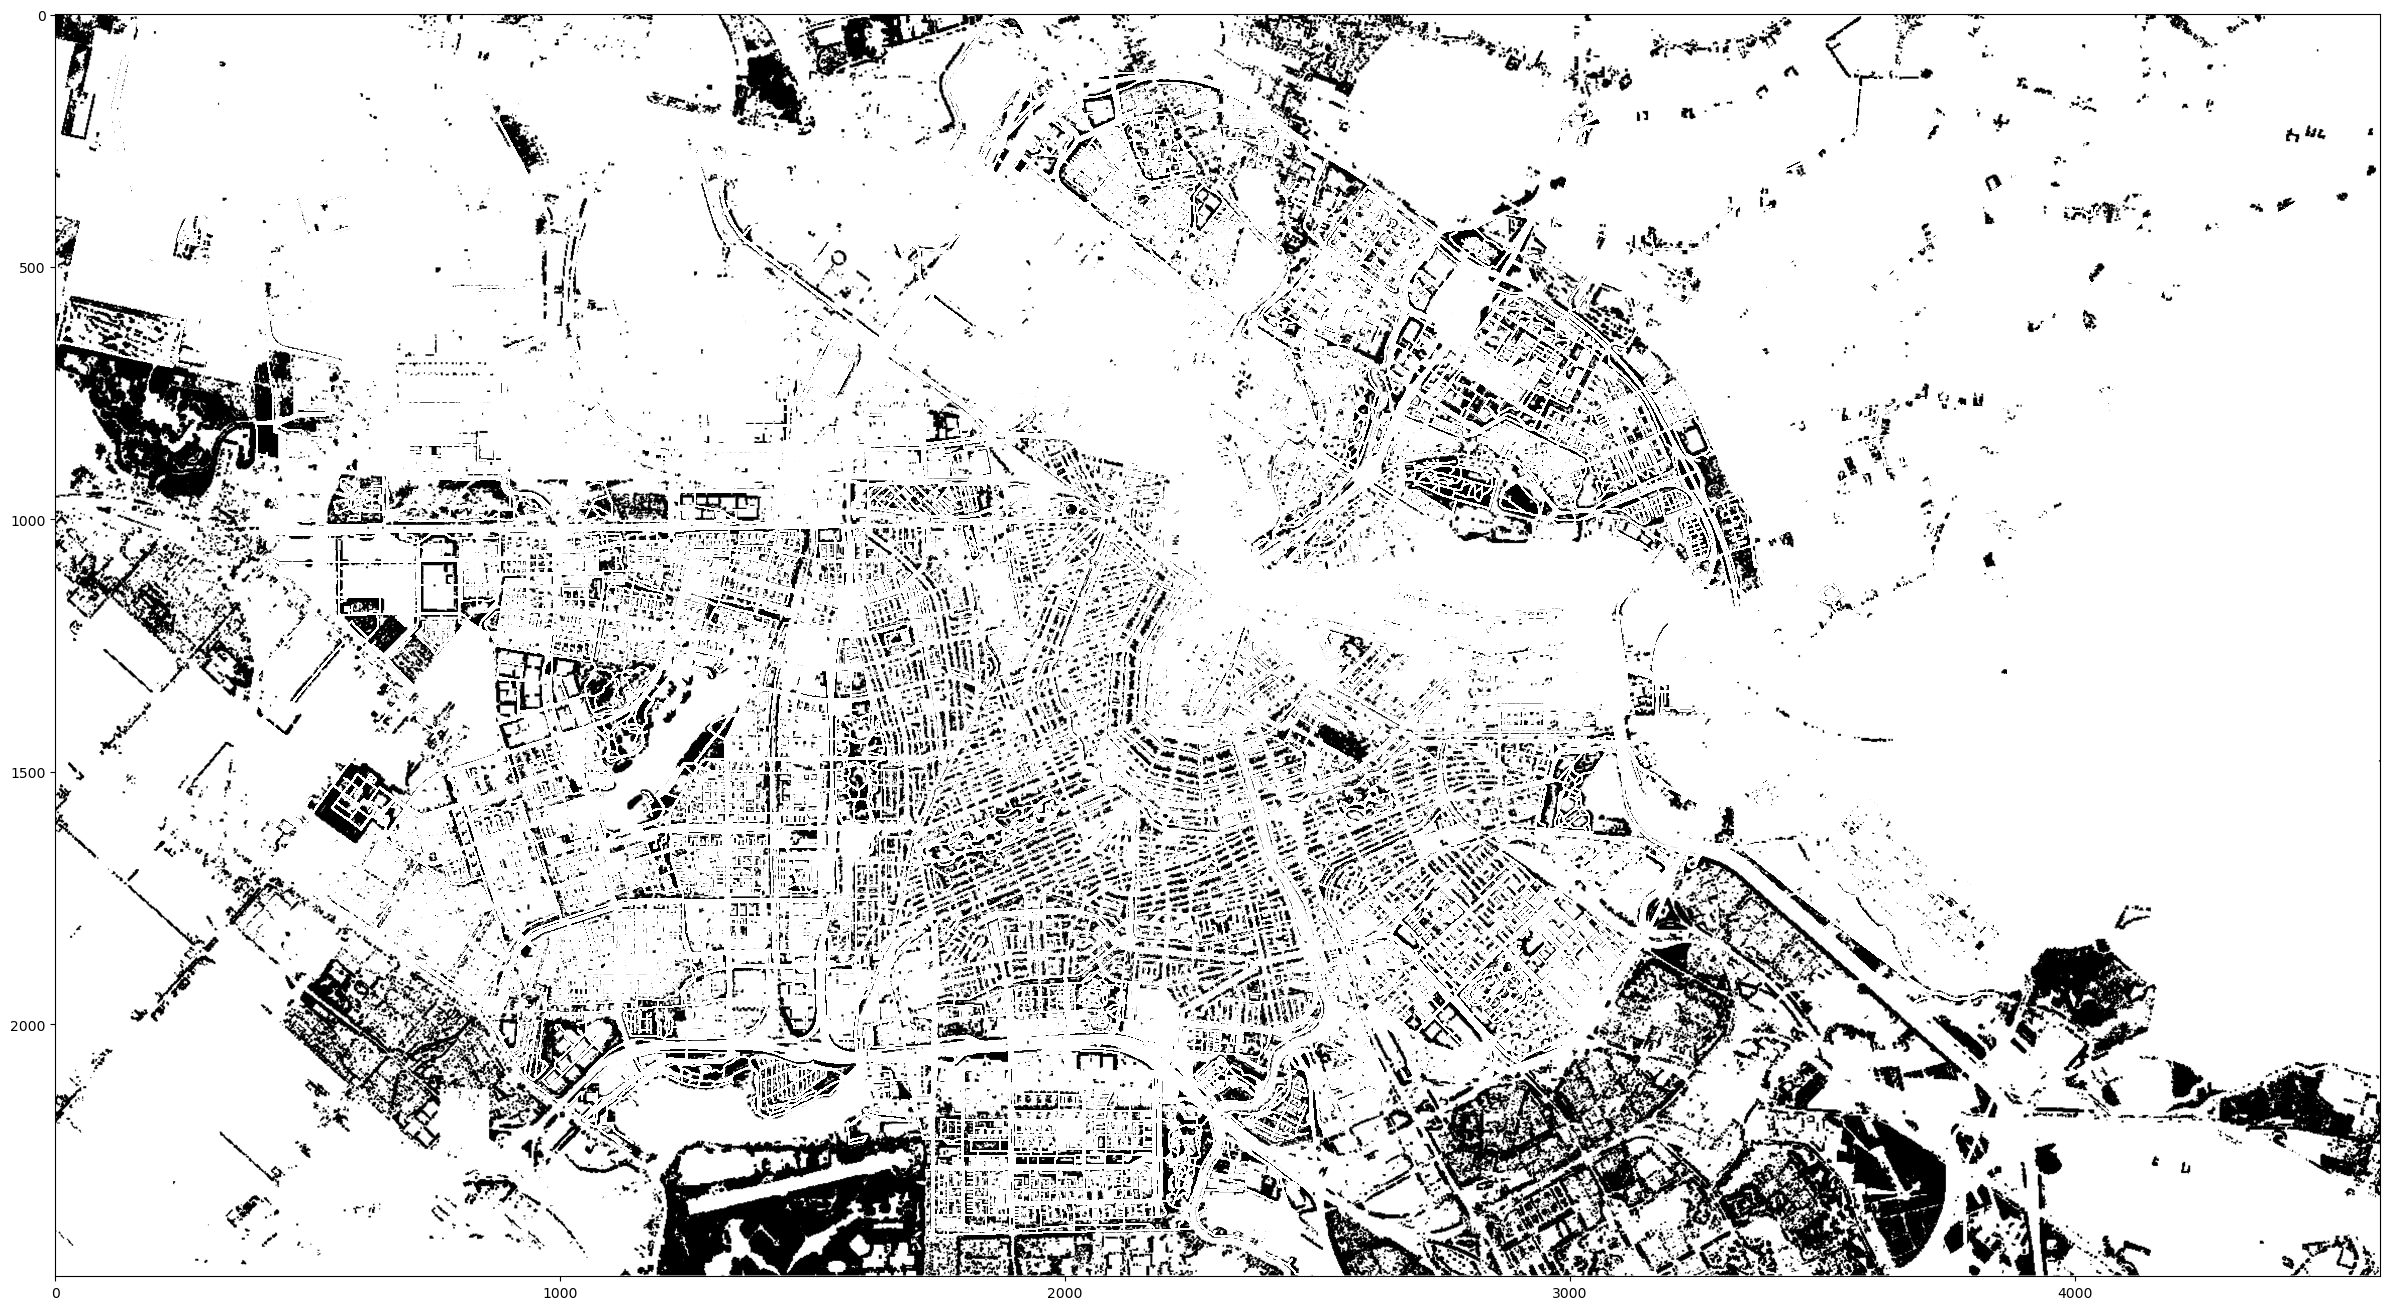

In [71]:
# visualise the masked_green_streets
fig, ax = plt.subplots(figsize=(30, 30))
ax.imshow(masked_green_streets, cmap='binary')
plt.show()

In [83]:
import rasterio
from shapely import geometry as geom

# load the DSM, DTM, and Green data
dsm_path = 'DSM_merged_ams.tif'
dtm_path = 'DTM_ams.tif'
green_path = '20200629_gm_Bomenkaart_v2_resampled_ams_trees.tif'


with rasterio.open(dsm_path) as src:
    dsm = src.read(1)

with rasterio.open(dtm_path) as src:
    dtm = src.read(1)
    meta = {
        'height': dtm.shape[0],
        'width': dtm.shape[1],
        'transform': src.transform,
        "driver": "GTiff",
        'count': 1,
        "crs": src.crs
    }

with rasterio.open(green_path) as src:
    green = src.read(1)

    
aoi = geom.Polygon([(121798.636, 487713.151), (121885.092, 487713.151), (121885.092, 487769.292), (121798.636, 487769.292)])
# aoi = geom.Polygon([(121824.136, 487727.651), (121859.592, 487727.651), (121859.592, 487755.292), (121824.136, 487755.292)])

options = {
    'radius': 500,  # 500 meters
    'o_height': 1.7,  # 1.7 meters (typical height of a person)
    't_height': 0  # 0 meters (the target is the ground)
}

mask = {
    'meta': meta,
    'aoi': aoi,
    'options': options,
    'dsm': np.ma.array(dsm, mask=(mask_streets == 0)),
    'dtm': np.ma.array(dtm, mask=(mask_streets == 0)),
    'green': np.ma.array(green, mask=((mask_streets == 0) | (mask == 0)))
}

result = f2(mask)

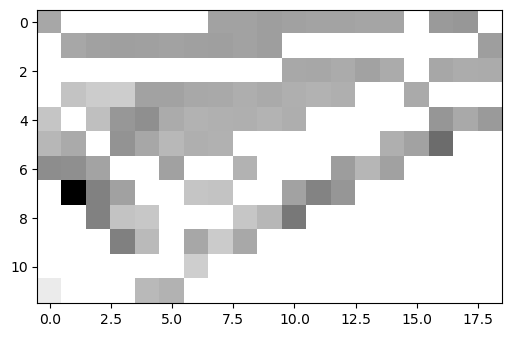

In [85]:
# visualise the result
with rasterio.open('tmp/31a4a2b5.tif') as src:
    gvi = src.read(1)
    
# visualise the masked_green_streets
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(gvi, cmap='binary')
plt.show()

### OSM building network data

In [1]:
import osmnx as ox
import geopandas as gpd

# region specificaiton
region = "Amsterdam"
gdf_buildings = ox.geometries_from_place(region, tags={'building':True})

# reproject
gdf_buildings = gdf_buildings.to_crs('EPSG:28992')

C:\Users\Ondrej\miniconda3\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\Ondrej\miniconda3\lib\site-packages\osmnx\projection.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/

In [95]:
# save the data
gdf_buildings[['addr:postcode', 'geometry']].to_file("buildings_osm/buildings.geojson", driver='GeoJSON')

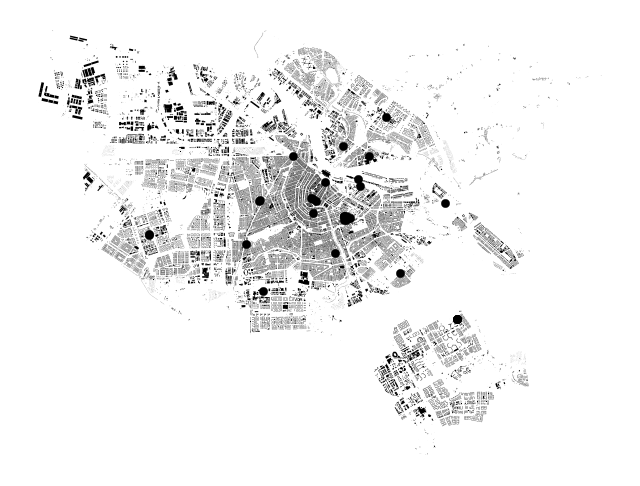

In [3]:
# visualise the street network
ax = gdf_buildings.plot(color='black', linewidth=0.3, figsize=(8, 8))
ax.set_axis_off()

###  GVI calculation - buildings

In [10]:
import rasterio
from shapely import geometry as geom

dsm_path = 'DSM_merged_ams.tif'
dtm_path = 'DTM_ams.tif'
green_path = '20200629_gm_Bomenkaart_v2_resampled_ams_trees.tif'


with rasterio.open(dsm_path) as src:
    dsm = src.read(1)

with rasterio.open(dtm_path) as src:
    dtm = src.read(1)
    meta = {
        'height': dtm.shape[0],
        'width': dtm.shape[1],
        'transform': src.transform,
        "driver": "GTiff",
        'count': 1,
        "crs": src.crs
    }

with rasterio.open(green_path) as src:
    green = src.read(1)

    
# create a list of all the geometries in the gdf_buildings dataframe
geoms = list(gdf_buildings.geometry.values)

# mask for all geometries
mask_buildings = rasterio.features.geometry_mask(geoms, out_shape=dsm.shape, transform=meta['transform'], invert=False)
mask_buildings = mask_buildings.astype(int) # convert to boolean

# use the mask on the DSM, DTM, and tree data
dsm_buildings = np.ma.array(dsm, mask=(mask_buildings == 0))
dtm_buildings = np.ma.array(dtm, mask=(mask_buildings == 0))
masked_green_buildings = np.ma.array(green, mask=((mask_buildings == 0) | (mask == 0)))
    
aoi = geom.Polygon([(121798.636, 487713.151), (121885.092, 487713.151), (121885.092, 487769.292), (121798.636, 487769.292)])
# aoi = geom.Polygon([(121824.136, 487727.651), (121859.592, 487727.651), (121859.592, 487755.292), (121824.136, 487755.292)])

options = {
    'radius': 500,  # 500 meters
    'o_height': 1.7,  # 1.7 meters (typical height of a person)
    't_height': 0  # 0 meters (the target is the ground)
}

mask = {
    'meta': meta,
    'aoi': aoi,
    'options': options,
    'dsm': np.ma.array(dsm, mask=(mask_buildings == 0)),
    'dtm': np.ma.array(dtm, mask=(mask_buildings == 0)),
    'green': np.ma.array(green, mask=((mask_buildings == 0) | (mask == 0)))
}

result = f2(mask)

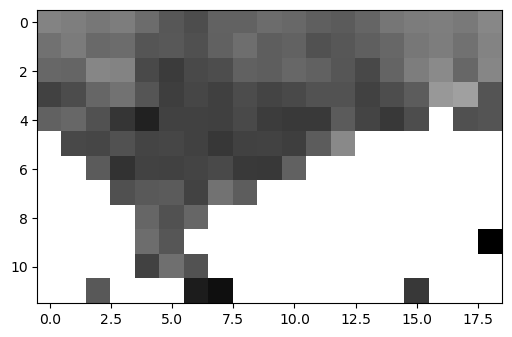

In [11]:
# visualise the result
with rasterio.open('tmp/ceb977fd.tif') as src:
    gvi = src.read(1)
    
# visualise the masked_green_streets
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(gvi, cmap='binary')
plt.show()